# Conditional Generative Adversarial Networks (cGAN)

- Generative Adversarial Networks (GANs) are an architecture for training generative models such as a deep convolutional neural networks for generating images.

- A limitation of a GAN model is that it may generate random images from the domain. This is due to the complex relationship between points in the latent space and the generated images which hard to map.

- Alternately, a GAN can be trained in such a way that both the generator and the discriminator models are conditioned on the class label. This means that when the trained generator model is used as a standalone model to generate images in the domain, images of a given type or class label can be generated.

> __Conditional Generative Adversarial Network or cGAN, is a type of GAN that involves conditional generation of images by a generator model. Image generation can be conditional on a class label (if available), allowing targeted generation of images of a given type.__

- There are two motivations for making use of the class label information in a GAN model.

     - __Improve the GAN__ :- Additional information that is correlated with the input images such as class labels can be used to improve the GAN. This improvement may come in the form of more stable training, faster training and/or generated images that have better quality.
        
     - __Targeted Image Generation__ :- Class labels can also be used for deliberate or targeted generation of images of a given type.

Below image provides the architecture of Conditonal GAN (cGAN).

<br>

![cGAN](cGAN_overview.jpg)

<br>

- The cGAN was first described by Mehdi Mirza and Simon Osindero in their 2014 paper titled [“Conditional Generative Adversarial Nets"](https://arxiv.org/abs/1411.1784). Their approach is demonstrated in the MNIST handwritten digit dataset where the class labels are one hot encoded and concatenated with the input to both the generator and discriminator models.

    
You can visit this [link](https://github.com/tdikonda/deep_learning/blob/master/Generative_Adversarial_Networks_(GANs)/Deep_Convolution_GAN_on_MNIST_Dataset_using_Keras/Deep_Convolution_GAN_(DCGAN)_on_MNIST_Dataset_using_Keras.ipynb) to understand basics of Generative Adversarial Networks (GANs)

### Lets begin with the implementation of Conditional Generative Adversial Networks (cGANs)

## Check Google Colaboratory Jupyter Notebook Runtime Type and Load Necessary Libraries

In [0]:
# check if the Google Colaboratory Jupyter notebook is running on a GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# import necessary libraries
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import Concatenate
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomNormal
from keras.datasets import fashion_mnist
from IPython.display import Image
import glob
import imageio
import time

Using TensorFlow backend.


## Explore Fashion MNIST Clothing Photograph Dataset

- It is a dataset comprised of 70,000 small square 28×28 pixel grayscale images of items of 10 types of clothing such as shoes, t-shirts, dresses and more.

- Keras provides access to the Fashion-MNIST dataset via the fashion_mnist.load_dataset( ) function. It returns two tuples, one with the input and output elements for the standard training dataset and another with the input and output elements for the standard test dataset.

In [0]:
# load images
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 2s 0us/step


In [0]:
# check data shape
print(f'X Train shape {X_train.shape}, Y Train shape {y_train.shape}')
print(f'X Test shape {X_test.shape}, Y Test shape {y_test.shape}')

X Train shape (60000, 28, 28), Y Train shape (60000,)
X Test shape (10000, 28, 28), Y Test shape (10000,)


> We can see that there are 60K examples in the training set and 10K in the test set and that each image is a square of 28 by 28 pixels.

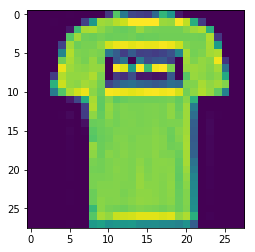

In [0]:
# check one of the train images
plt.imshow(X_train[1])

> The images are grayscale with a black background (0 pixel value) and the items of clothing are in white (pixel values near 255). This means if the images were plotted, they would be mostly black with a white item of clothing in the middle.

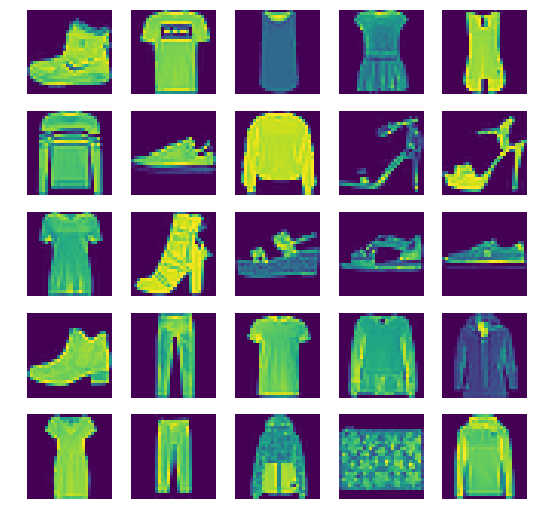

In [0]:
# checkout first 25 images
fig = plt.figure(figsize=(9,9))
    
# plot images
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_train[i])

## Build Generator Model

- The best way to design models in Keras to have multiple inputs by using Functional API as opposed to Sequential API

- There are many ways to encode and incorporate the class labels into the discriminator and generator models. A best practice involves using an embedding layer followed by a fully connected layer with a linear activation that scales the embedding to the size of the image before concatenating it in the model as an additional channel or feature map.

- For the generator, the class label is passed through an embedding layer to map it to a unique 50 element vector and is then passed through a fully connected layer with a linear activation before being resized. In this case, the activations of the fully connected layer are resized into a single 7×7 feature map. This is to match the 7×7 feature map activations of the unconditional generator model. The new 7×7 feature map is added as one more channel to the existing 128, resulting in 129 feature maps that are then upsampled as in the DCGAN generator model.

- The generator model takes input of points in latent space and outputs a single 28×28 grayscale image. This is achieved by using a fully connected layer to interpret the point in the latent space and provide sufficient activations that can be reshaped into many copies (in this case 128) of a low-resolution version of the output image (e.g. 7×7). This is then upsampled twice, doubling the size and quadrupling the area of the activations each time using transpose convolutional layers. The model uses best practices such as the kernel initialization using Gaussian Weight,  a kernel size that is a factor of the stride size, LeakyReLU activation with a slope of 0.2, Batchnormalization with momentum of 0.8 and a hyperbolic tangent (tanh) activation function in the output layer.

### Recommendation for Discrete Variables in Conditional GANs

- Use an Embedding layer

- Add as additional channels to images

- Keep embedding dimensionality low and upsample to match image channel size


In [0]:
# define generator model
def build_generator(latent_dim=300, n_classes=10):
    # initialize Gaussian Weight
    init = RandomNormal(mean=0.0, stddev=0.02)
    # input label
    input_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(input_label)
    # linear multiplication
    li = Dense(7 * 7, kernel_initializer=init)(li)
    # Reshape for additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    input_image = Input(shape=(latent_dim,))
    
    # base 7x7 image
    gen = Dense(128 * 7 * 7, kernel_initializer=init)(input_image)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    
    # merge image generator and input label
    merge = Concatenate()([gen, li])
    
    # upsample from 7x7 to 14x14
    gen = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # upsample from 14x14 to 28x28
    gen = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # output 28x28x1
    output_layer = Conv2D(1, kernel_size=(4,4), padding='same', activation='tanh')(gen)
    
    # define model
    model = Model([input_image, input_label], output_layer)
    return model

# create the generator model
g_model = build_generator()

# generator model summary
g_model.summary()







Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 6272)         1887872     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_1[0][0]                    
______________________________________________________________________________________

### Plot Generator Model


>  We can see the 300 element point in latent space as input and subsequent resizing (left) and the new class label input and embedding layer (right), then the concatenation of the two sets of feature maps (center). The remainder of the model is the same as the generator model used in DCGAN.



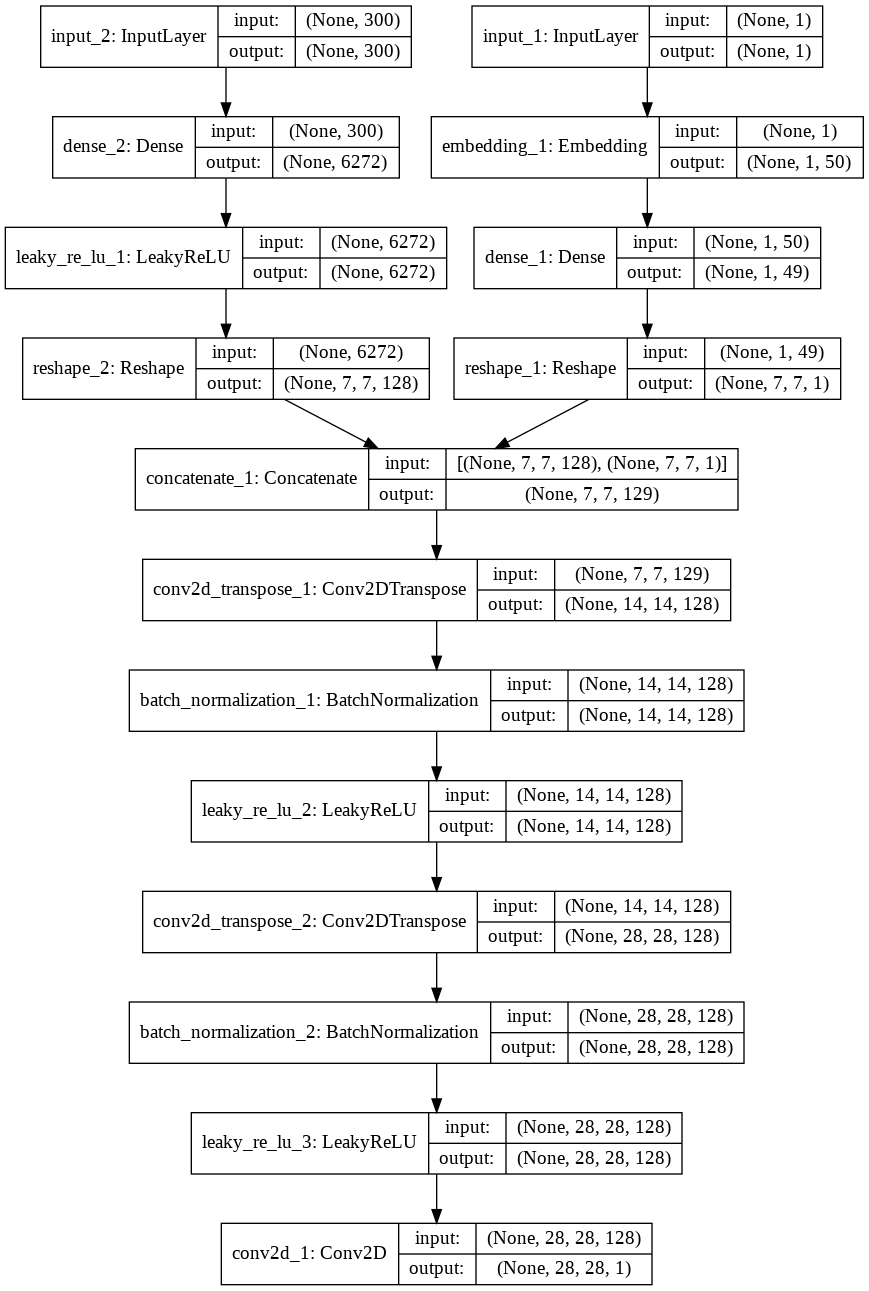

In [0]:
# plot Generator Model
plot_model(g_model, to_file='cgan_generator_model_plot.png', show_shapes=True, show_layer_names=True)
Image(filename='cgan_generator_model_plot.png', retina=True)

## Build Discriminator Model

- For the discriminator model, a new second input is defined that takes an integer for the class label of the image. This has the effect of making the input image conditional on the provided class label.

- The class label is then passed through an Embedding layer with the size of 50. This means that each of the 10 classes for the Fashion MNIST dataset (0 through 9) will map to different 50 element vector representation that will be learned by the discriminator model.

- The output of the embedding is then passed to a fully connected layer with a linear activation. Importantly, the fully connected layer has enough activations that can be reshaped into one channel of a 28×28 image. The activations are reshaped into single 28×28 activation map and concatenated with the input image. This has the effect of looking like a two-channel input image to the next convolutional layer.

- The discriminator model takes input of 28×28 grayscale image and outputs a binary prediction as to whether the image is real (class=1) or fake (class=0). It is implemented as a modest convolutional neural network using best practices for GAN design such as using a 2×2 stride to downsample, a kernel size that is a factor of the stride size, kernel initialization using Gaussian Weight, LeakyReLU activation function with a slope of 0.2, Batchnormalization with momentum of 0.8, Dropout with a rate of 0.5 and the adam version of stochastic gradient descent with a learning rate of 0.0002 and a momentum of 0.5.

- The build_discriminator( ) below implements this update to the discriminator model. The parameterized shape of the input image is also used after the embedding layer to define the number of activations for the fully connected layer to reshape its output. The number of classes in the problem is also parameterized in the function and set.

### Recommendation for Discrete Variables in Conditional GANs

- Use an Embedding layer

- Add as additional channels to images

- Keep embedding dimensionality low and upsample to match image channel size

In [0]:
# define discriminator model
def build_discriminator(input_shape=(28,28,1), n_classes=10):
    # initialize Gaussian Weight
    init = RandomNormal(mean=0.0, stddev=0.02)
    # input label
    input_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(input_label)
    # scale up to image dimensions with linear activation
    li = Dense(input_shape[0] * input_shape[1])(li)
    # Reshape for additional channel
    li = Reshape((input_shape[0], input_shape[1], 1))(li)
    # input image
    input_image = Input(shape=input_shape)
    # concatenate label as a channel
    merge = Concatenate()([input_image, li])
    
    # input 28x28 real and fake images and downsample from 28x28 to 14x14
    dis = Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    dis = LeakyReLU(alpha=0.2)(dis)
    dis = Dropout(0.5)(dis)
    
    # 2D Convolution Layer
    dis = Conv2D(filters=128, kernel_size=(4,4), padding='same', kernel_initializer=init)(dis)
    dis = BatchNormalization(momentum=0.8)(dis)
    dis = LeakyReLU(alpha=0.2)(dis)
    dis = Dropout(0.5)(dis)

    # downsample from 14x14 to 7x7
    dis = Conv2D(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(dis)
    dis = BatchNormalization(momentum=0.8)(dis)
    dis = LeakyReLU(alpha=0.2)(dis)
    dis = Dropout(0.5)(dis)
    
    # 2D Convolution Layer
    dis = Conv2D(filters=512, kernel_size=(4,4), padding='same', kernel_initializer=init)(dis)
    dis = BatchNormalization(momentum=0.8)(dis)
    dis = LeakyReLU(alpha=0.2)(dis)
    dis = Dropout(0.5)(dis)
    
    # flatten feature maps
    dis = Flatten()(dis)
    
    # output layer
    output_layer = Dense(1, activation='sigmoid')(dis)
    
    # define model
    model = Model([input_image, input_label], output_layer)
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# create the discriminator
d_model = build_discriminator()

# discriminator model summary
d_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1, 784)       39984       embedding_2[0][0]                
________________________________________________________________________________

### Plot Discriminator Model

> The plot shows the two inputs: first the class label that passes through the embedding (left) and the image (right), and their concatenation into a two-channel 28×28 image or feature map (middle). The rest of the model is the same as the discriminator model used in DCGAN.



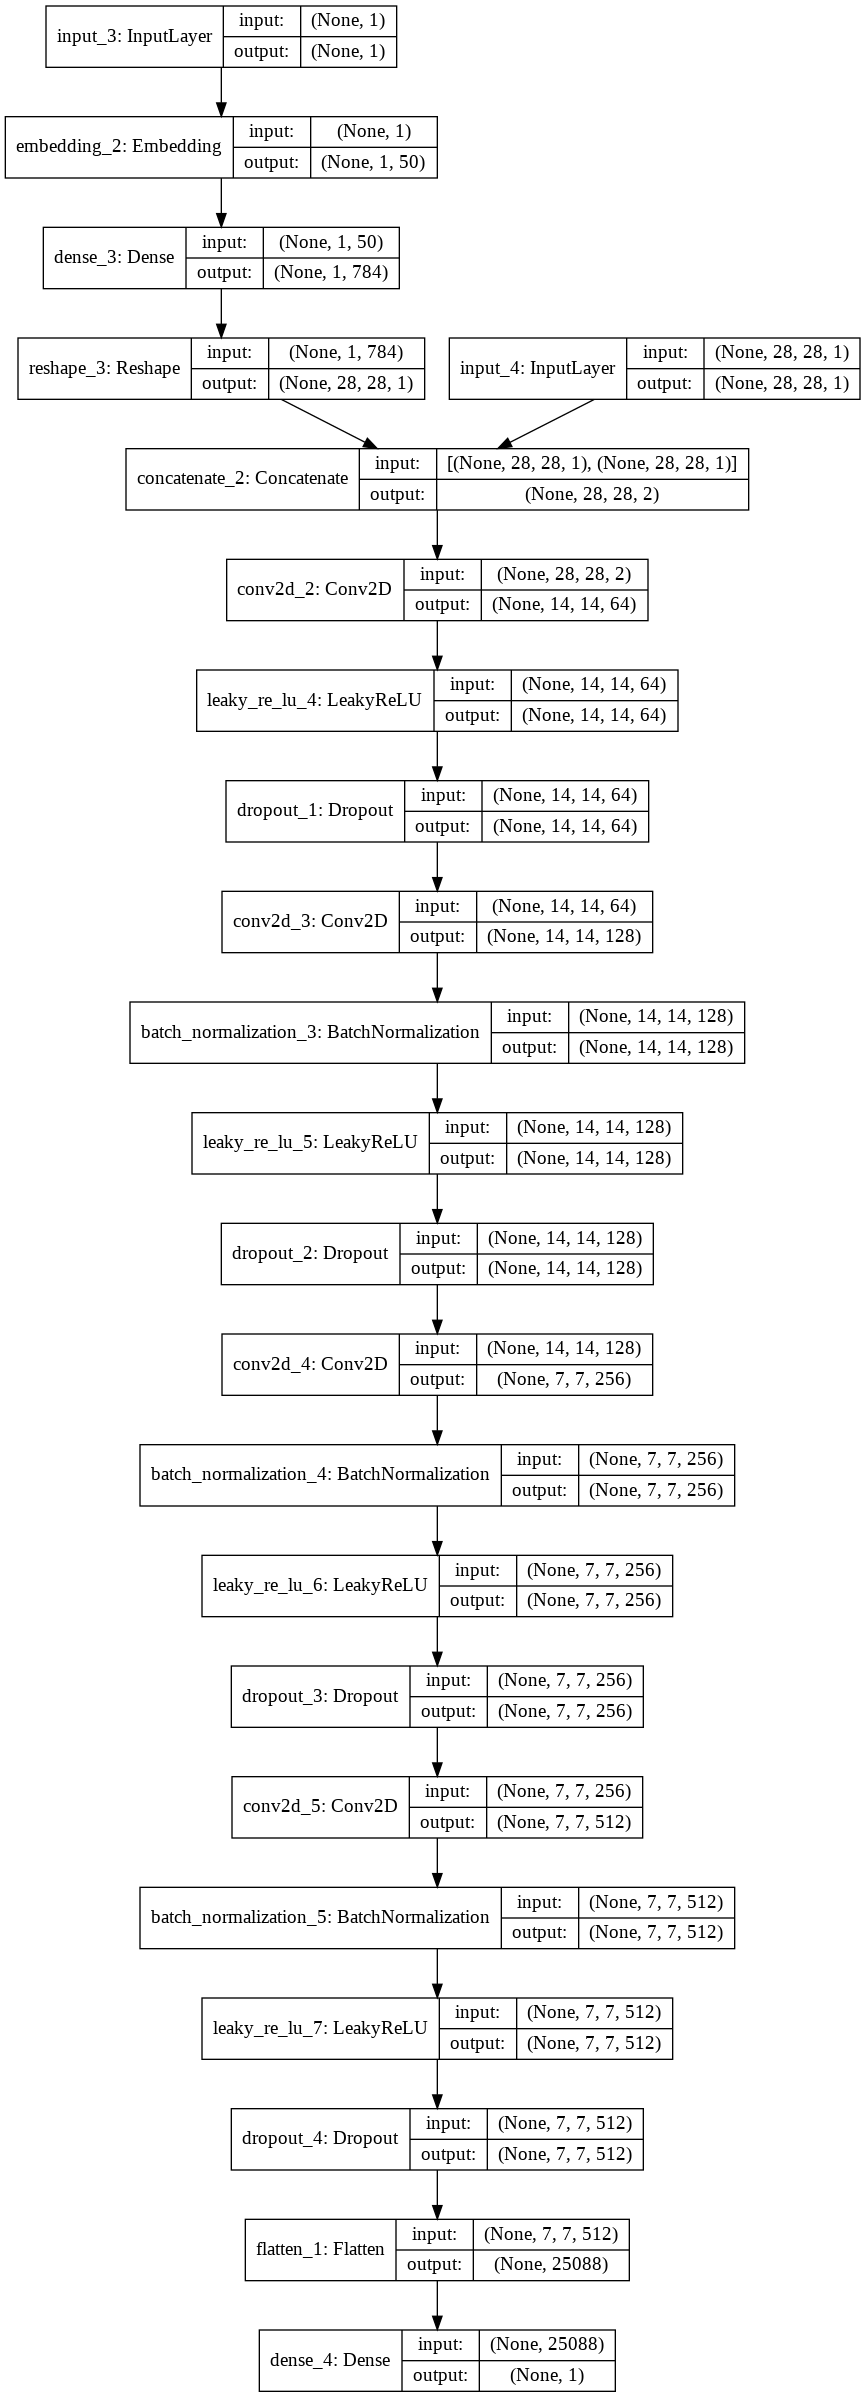

In [0]:
# plot Discriminator Model
plot_model(d_model, to_file='cgan_discriminator_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='cgan_discriminator_model_plot.png')

## Build GAN Model

- A composite GAN model can be defined that combines both the generator model and the discriminator model into one larger model. This model takes as input a point in the latent space, uses the generator model to generate an image which is fed as input to the discriminator model, then is output or classified as real or fake.

- This composite model will be used to train the model weights in the generator using the output and error calculated by the discriminator model. 

- The discriminator model is trained separately and as such the model weights are marked as not trainable in this larger GAN model to ensure that only the weights of the generator model are updated. This change to the trainability of the discriminator weights only has an effect when training the combined GAN model, not when training the discriminator standalone.

- Using the functional API to design the model, it is important that we explicitly connect the image generated output from the generator as well as the class label input, both as input to the discriminator model. This allows the same class label input to flow down into the generator and down into the discriminator.

In [0]:
# combine the generator and discriminator model for updating the generator
def build_gan(g_model, d_model):
    # Do not train weights in the discriminator for composite GAN model
    d_model.trainable = False
    # get noise and input label from generator model
    gen_noise, gen_label = g_model.input
    # get image output from generator model
    gen_output = g_model.output
    # connect image output and input label from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define GAN model taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

# create logical GAN model
gan_model = build_gan(g_model, d_model)

# logical GAN model summary
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 6272)         1887872     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_1[0][0]                    
____________________________________________________________________________________________

### Plot GAN Model

> The plot below summarizes the composite GAN model. Importantly, it shows the generator model in full with the point in latent space and class label as input and the connection of the output of the generator and the same class label as input to the discriminator model (last box at the bottom of the plot) and the output of a single class label classification of real or fake.



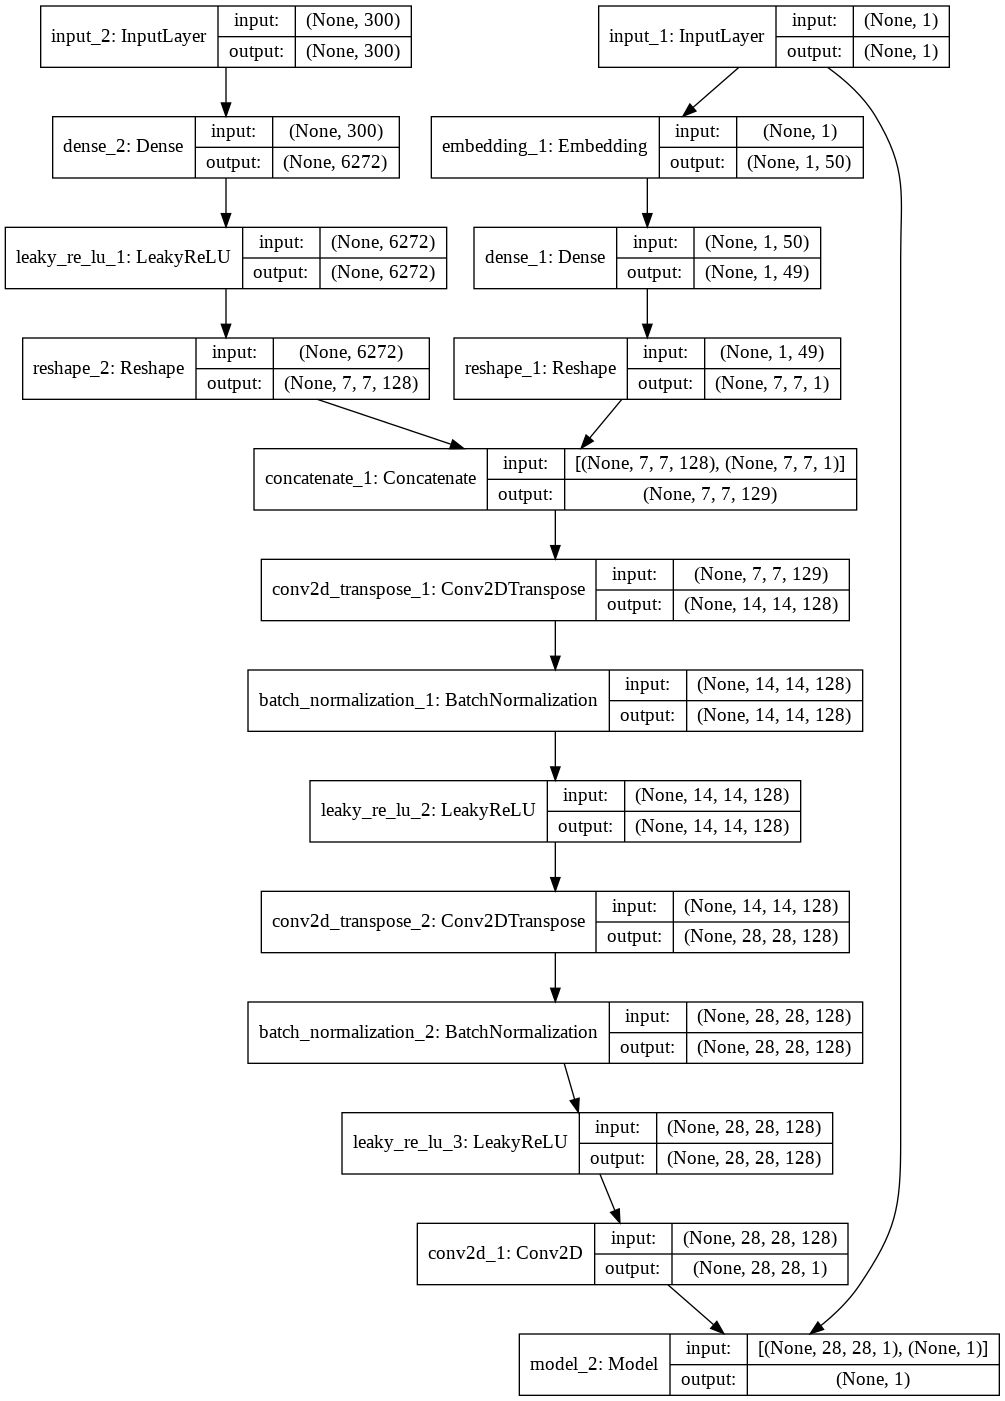

In [0]:
# plot GAN Model
plot_model(gan_model, to_file='cgan_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='cgan_plot.png')

## Load Real Image Dataset

- The Fashion MNIST input data needs to be loaded and prepared. We only require the images in the training dataset. The images are black and white, therefore we must add an additional channel dimension to transform them to be three dimensional, as expected by the convolutional layers of our models. 

- The pixel values must also be scaled from the range of unsigned integers in [0,255] to the normalized range of [-1,1] to match the output of the generator model.

In [0]:
# load and prepare Fashion MNIST training images and labels
def load_real_samples():
    # load fashion_mnist dataset
    (X_train, y_train), (_, _) = fashion_mnist.load_data()
    # expand to 3D i.e add channel dimension
    X_train = expand_dims(X_train, axis=-1)
    # convert from unsigned ints to floats
    X_train = X_train.astype('float32')
    # scale from [0,255] to [0,1]
    #dataset = train_images / 255.0
    # scale from [0,255] to [-1,1]
    X_train = (X_train - 127.5) / 127.5
    return [X_train, y_train]

## Get Random Real Image Samples

- We will require batches of real images from the dataset to update the GAN model. A simple way to achieve this is to select a random sample of images from the dataset each time.

- The get_real_samples( ) function below implements this, taking the prepared dataset, selecting and returning a random sample of Fashion MNIST images and their corresponding class label for the discriminator, specifically class=1 indicating that they are real images.


In [0]:
# get random real image samples
def get_real_samples(dataset, n_samples):
    # split dataset into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # retrieve random images and its corresponding labels
    X_real, labels_real = images[ix], labels[ix]
    # generate 'real' class labels (1)
    y_real = ones((n_samples, 1))
    return [X_real, labels_real], y_real

## Generate Latent Points

- We need inputs for the generator model. These are random points from latent space, specifically Gaussian distributed random variables.

- The generate_latent_points( ) function must also be updated to generate an array of randomly selected integer class labels to go along with the randomly selected points in the latent space.

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate input labels
    input_labels = randint(0, n_classes, n_samples)
    return [z_input, input_labels]

## Generate Fake Image Samples

- The generate_fake_samples( ) function returns fake generated images and their corresponding class label for the discriminator model, specifically class=0 to indicate they are fake or generated.



In [0]:
# use the generator to generate n fake examples with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_fake = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X_fake = g_model.predict([z_input, labels_fake])
    # create 'fake' class labels (0)
    y_fake = zeros((n_samples, 1))
    return [X_fake, labels_fake], y_fake

## Plot Generated Fake Images

- The plot_images( ) function below plots fake/generated clothing item images after specific epochs, which are organized in columns from left to right. The clothing items are 't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag' and 'ankle boot'.

In [0]:
# plot and save generated images
def plot_images(X_fake, epoch):
    # set figure size
    fig = plt.figure(figsize=(17,8))
    
    # plot images
    for i in range(50):
        # define subplot
        plt.subplot(5, 10, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(X_fake[i, :, :, 0])
    # save plot to file
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    # show the image
    plt.show()

## Summarize Performance

- There are no reliable ways to determine when to stop training a GAN; instead images can be subjectively inspected in order to choose a final model.

- Therefore, we can periodically generate a sample of images using the generator model and save the generator model to file for later use. The summarize_performance( ) function below implements this. Generating 50 images, plotting them, saving the plot and the generator model to a file with a filename that includes the training “epoch” number.

- Discriminator's Loss on Real and Fake Images and Generator's Loss is reported every 5 epochs.

In [0]:
def summarize_performance(i, d_loss_real, d_loss_fake, g_loss, latent_dim, g_model):
    # print epoch
    print(f'Epoch --> {i+1}')
    # get Discriminator and Generator Loss
    print(f"Discriminator's Loss on real: {d_loss_real:.4f} and fake: {d_loss_fake:.4f} Images; Generator's Loss: {g_loss:.4f}")
    # generate latent points
    latent_points, _ = generate_latent_points(latent_dim, n_samples=100)
    # generate labels
    labels = asarray([x for _ in range(10) for x in range(10)])
    # generate fake images
    X_fake = g_model.predict([latent_points, labels])
    # scale from [-1,1] to [1,0]
    X_fake = (X_fake + 1) / 2.0
    # plot generated images and save it
    plot_images(X_fake, i)
    # save the generator model to a file
    filename = 'cgan_generator_model_%03d.h5' % (i+1)
    g_model.save(filename)

## Plot Discriminator and Generator Loss

In [0]:
# plot Discriminator and Generator Loss
def plot_history(d_loss_real_hist, d_loss_fake_hist, g_loss_hist):
    plt.figure(figsize=(14,8))
    
    # plot Discriminator Loss
    plt.subplot(2, 1, 1)
    plt.plot(d_loss_real_hist, label="Discriminator's Loss on Real Images")
    plt.plot(d_loss_fake_hist, label="Discriminator's Loss on Fake Images")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Discriminator's Loss on Real and Fake Images")
    plt.legend()

    # plot Generator Loss
    plt.subplot(2, 1, 2)
    plt.plot(g_loss_hist, label="Generator's Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Generator's Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Train GAN

- The model is fit for 100 training epochs which is arbitrary. The model begins generating plausible items of clothing after 30 epochs. A batch size of 256 samples is used and each training epoch involves 60,000/256 or about 234 batches of real and fake samples and updates to the model.

- First, the discriminator model is updated for a half batch of real samples, then a half batch of fake samples, together forming one batch of weight updates. The generator is then updated via the composite gan model. Importantly, the class label is set to 1 or real for the fake samples. This has the effect of updating the generator toward getting better at generating real samples on the next batch.

- The train_gan( ) function below implements this, taking the defined models, dataset and size of the latent dimension as arguments and parameterizing the number of epochs and batch size with default arguments. The generator model is saved at the end of training. The function must be updated to retrieve and use the class labels in the calls for updating the discriminator and generator models.


In [0]:
# train the generator and discriminator
def train_gan(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch=256):
    # calculate number of batches per training epoch
    batch_per_epoch = int(dataset[0].shape[0] / n_batch)
    # calculate number of training iterations
    #iterations = batch_per_epoch * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # list for storing loss at each iteration
    d_loss_real_hist, d_loss_fake_hist, g_loss_hist = list( ), list( ), list( )
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over training set
        for j in range(batch_per_epoch):
            # get random 'real' samples
            [X_real, labels_real], y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' samples
            [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss_fake, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)
            # prepare points in latent space as input to the generator
            [z_input, input_labels] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via discriminator's error
            g_loss = gan_model.train_on_batch([z_input, input_labels], y_gan)
            # record history for Discriminator loss and Generator loss
            d_loss_real_hist.append(d_loss_real)
            d_loss_fake_hist.append(d_loss_fake)
            g_loss_hist.append(g_loss)
        # summarize performance at specific epoch
        if (i+1) % 5 == 0:
            summarize_performance(i, d_loss_real, d_loss_fake, g_loss, latent_dim, g_model)
            
    # save generator model
    #g_model.save('cdcgan_model.h5')
    # plot Discriminator and Generator Loss
    plot_history(d_loss_real_hist, d_loss_fake_hist, g_loss_hist)

## Run GAN

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch --> 5
Discriminator's Loss on real: 0.0932 and fake: 0.0299 Images; Generator's Loss: 7.1096


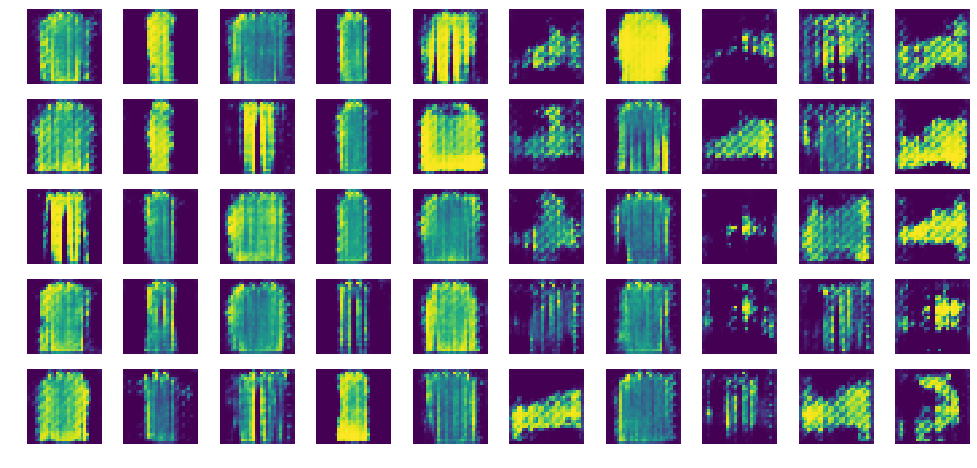

Epoch --> 10
Discriminator's Loss on real: 0.3481 and fake: 0.4418 Images; Generator's Loss: 4.2667


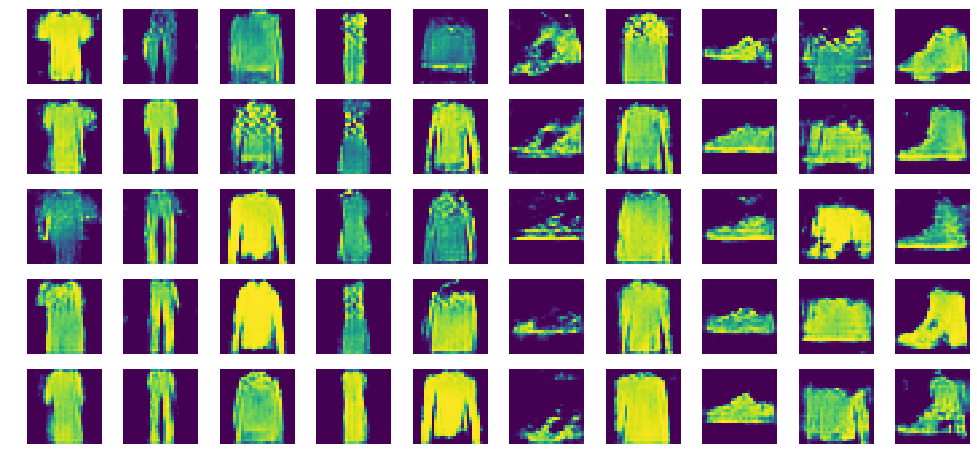

Epoch --> 15
Discriminator's Loss on real: 0.2484 and fake: 0.1904 Images; Generator's Loss: 2.9343


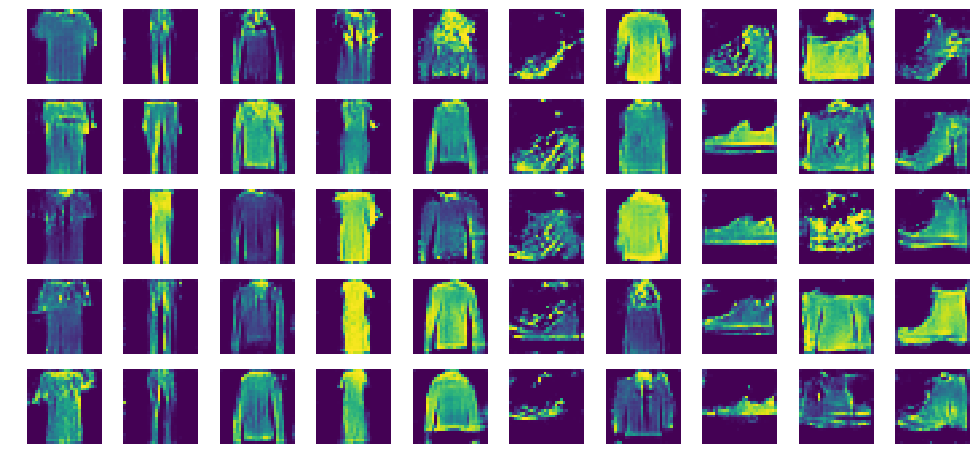

Epoch --> 20
Discriminator's Loss on real: 0.6181 and fake: 0.3598 Images; Generator's Loss: 3.6509


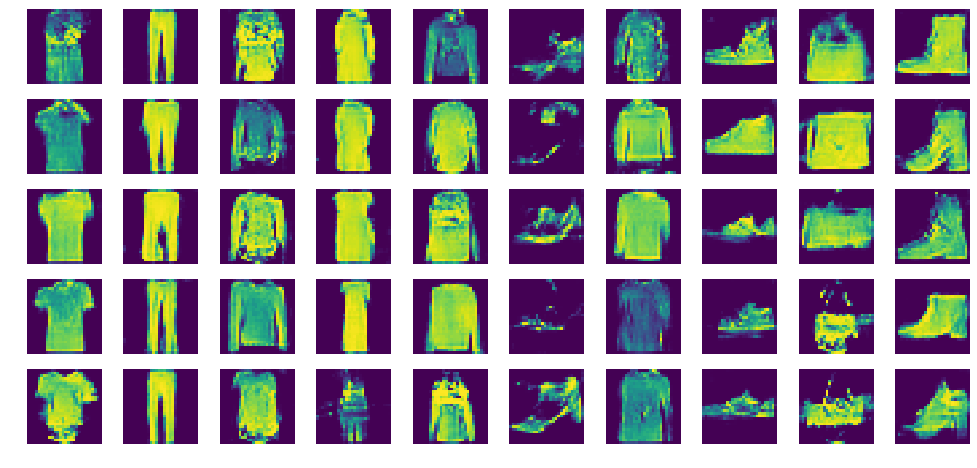

Epoch --> 25
Discriminator's Loss on real: 0.1629 and fake: 0.1461 Images; Generator's Loss: 2.7228


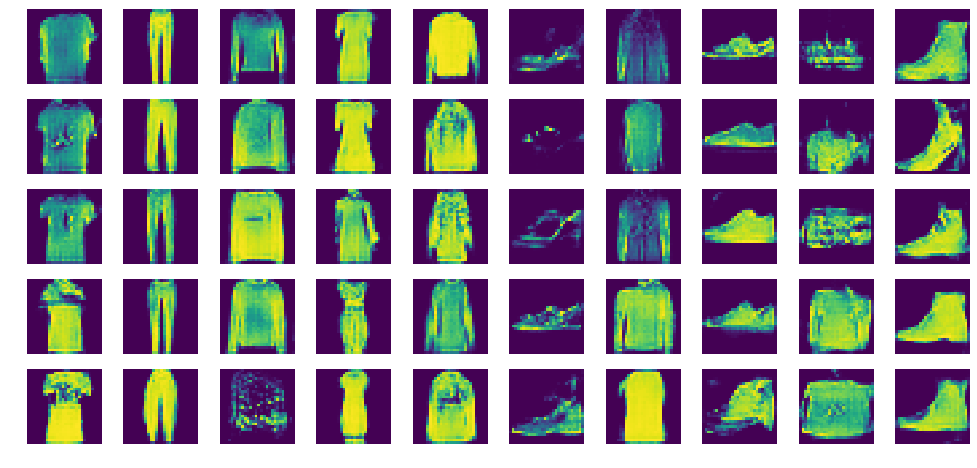

Epoch --> 30
Discriminator's Loss on real: 0.3401 and fake: 0.3429 Images; Generator's Loss: 4.1867


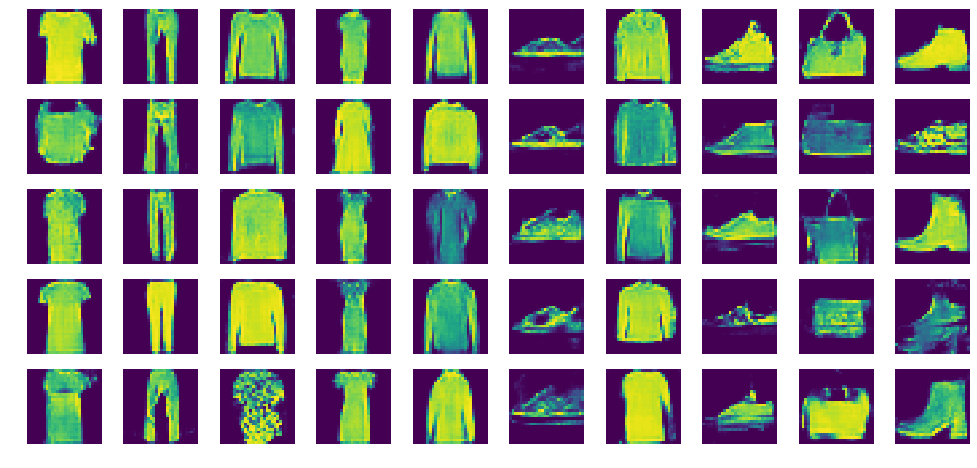

Epoch --> 35
Discriminator's Loss on real: 1.4842 and fake: 0.8320 Images; Generator's Loss: 2.4536


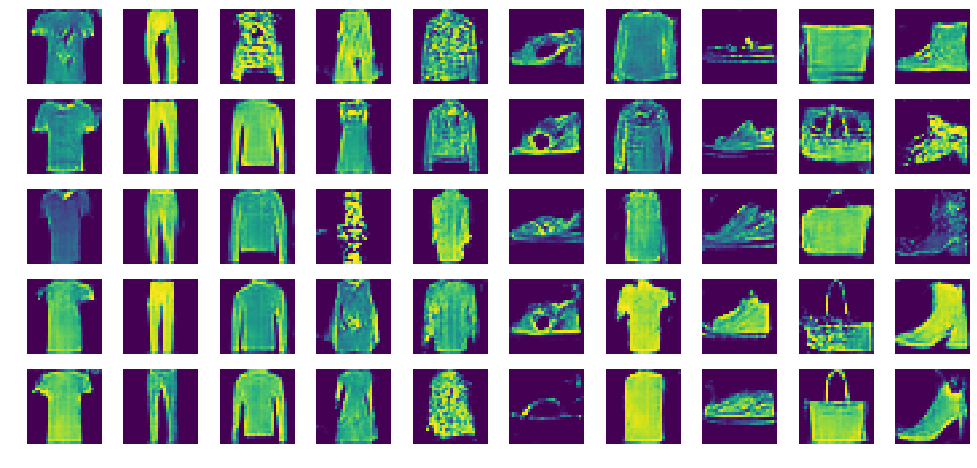

Epoch --> 40
Discriminator's Loss on real: 1.0907 and fake: 0.2773 Images; Generator's Loss: 3.1247


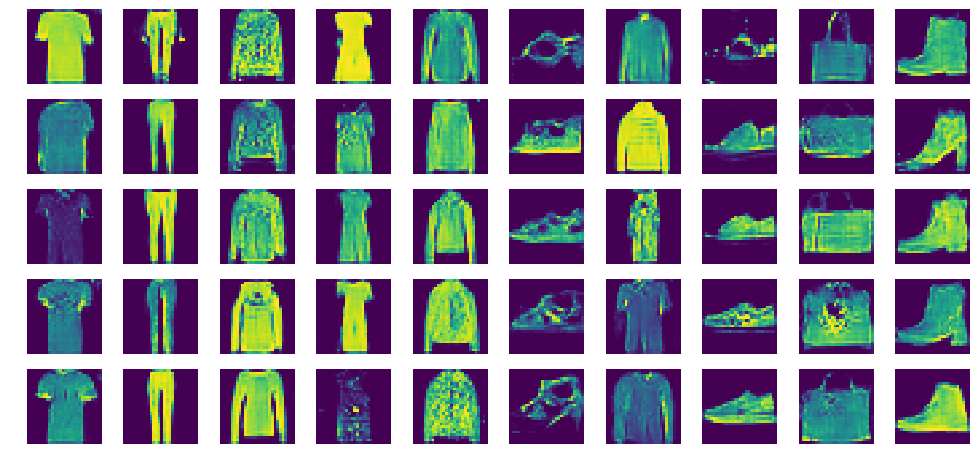

Epoch --> 45
Discriminator's Loss on real: 0.4737 and fake: 0.2866 Images; Generator's Loss: 3.2283


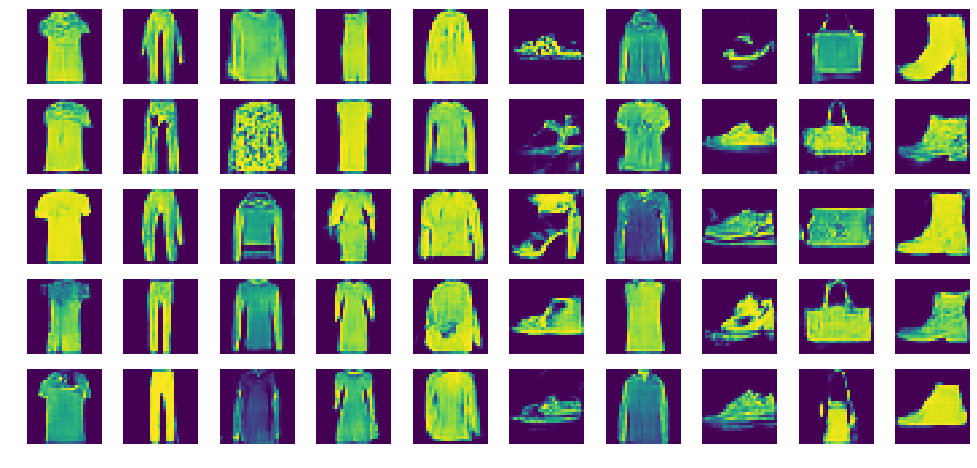

Epoch --> 50
Discriminator's Loss on real: 0.1826 and fake: 0.1816 Images; Generator's Loss: 2.8882


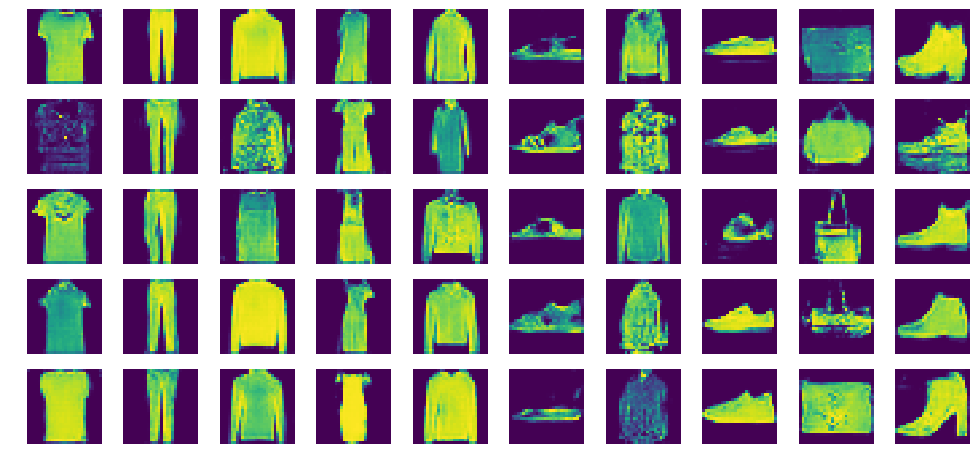

Epoch --> 55
Discriminator's Loss on real: 0.0620 and fake: 0.0946 Images; Generator's Loss: 3.2983


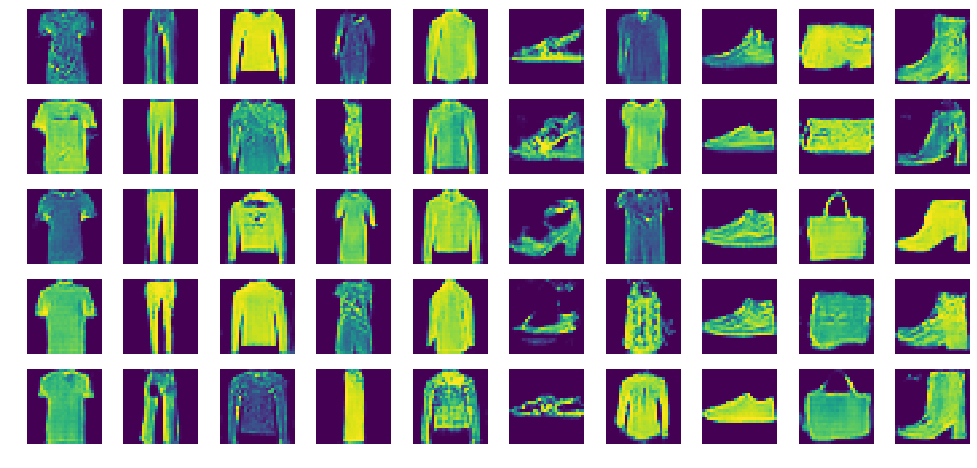

Epoch --> 60
Discriminator's Loss on real: 0.3055 and fake: 0.0267 Images; Generator's Loss: 3.9734


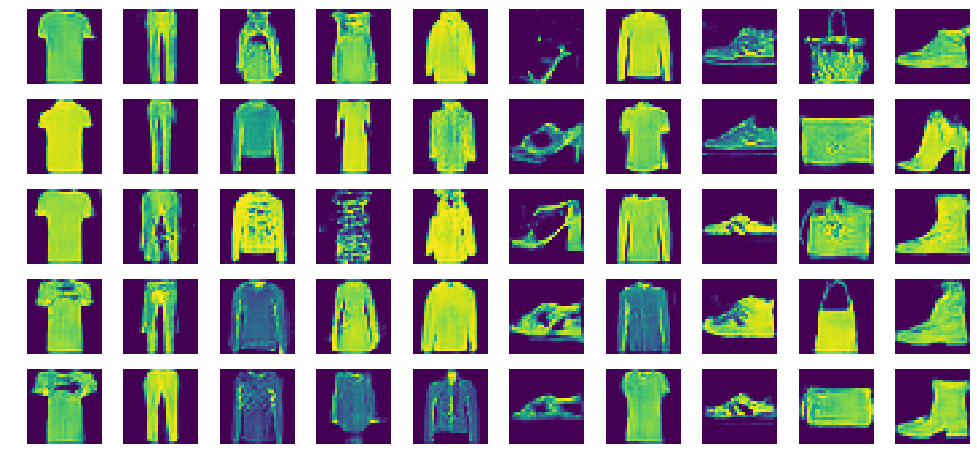

Epoch --> 65
Discriminator's Loss on real: 0.2295 and fake: 0.3045 Images; Generator's Loss: 4.2834


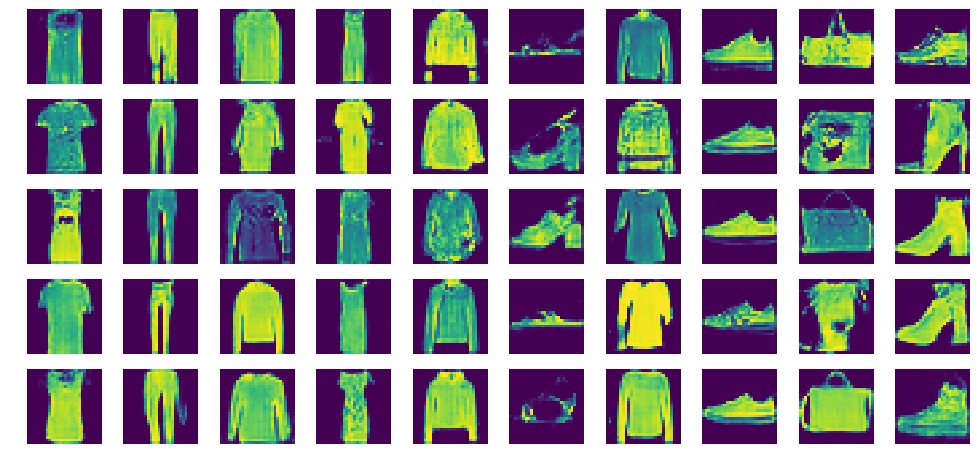

Epoch --> 70
Discriminator's Loss on real: 0.3326 and fake: 0.3982 Images; Generator's Loss: 3.3612


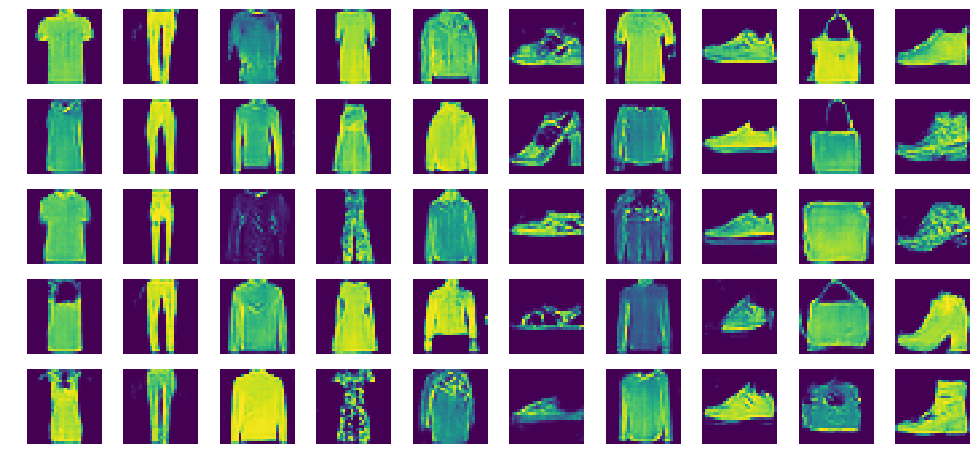

Epoch --> 75
Discriminator's Loss on real: 0.0862 and fake: 0.3409 Images; Generator's Loss: 3.5405


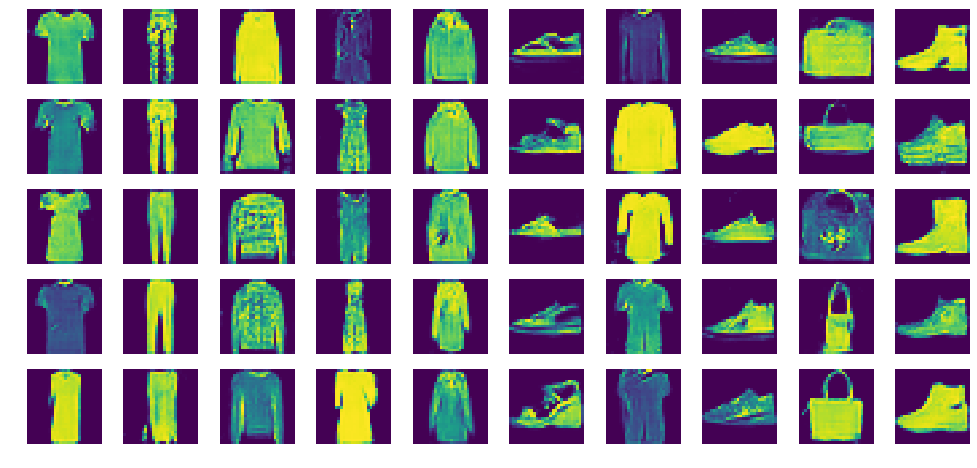

Epoch --> 80
Discriminator's Loss on real: 0.2593 and fake: 0.2771 Images; Generator's Loss: 2.7832


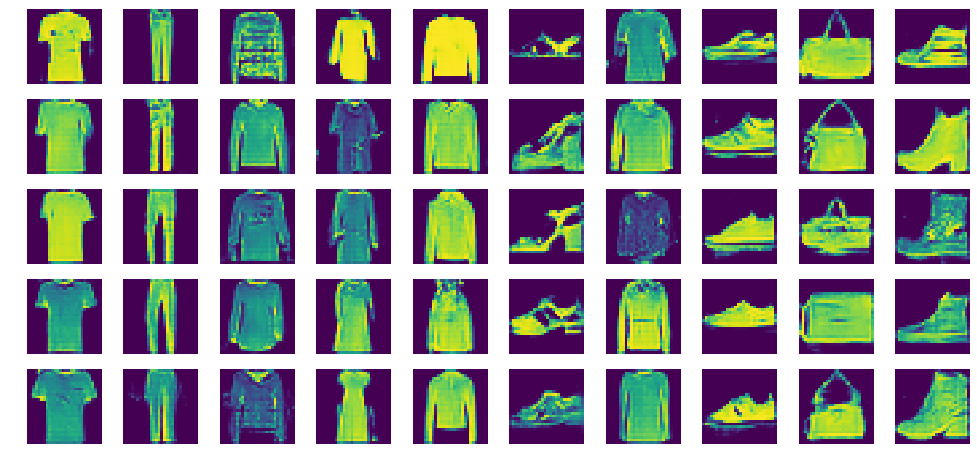

Epoch --> 85
Discriminator's Loss on real: 0.5607 and fake: 0.4689 Images; Generator's Loss: 4.0337


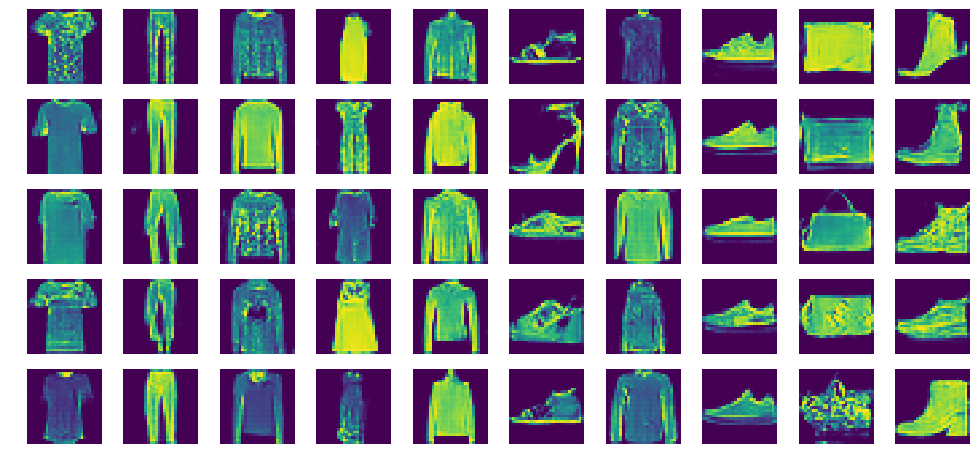

Epoch --> 90
Discriminator's Loss on real: 0.2633 and fake: 0.5681 Images; Generator's Loss: 4.2456


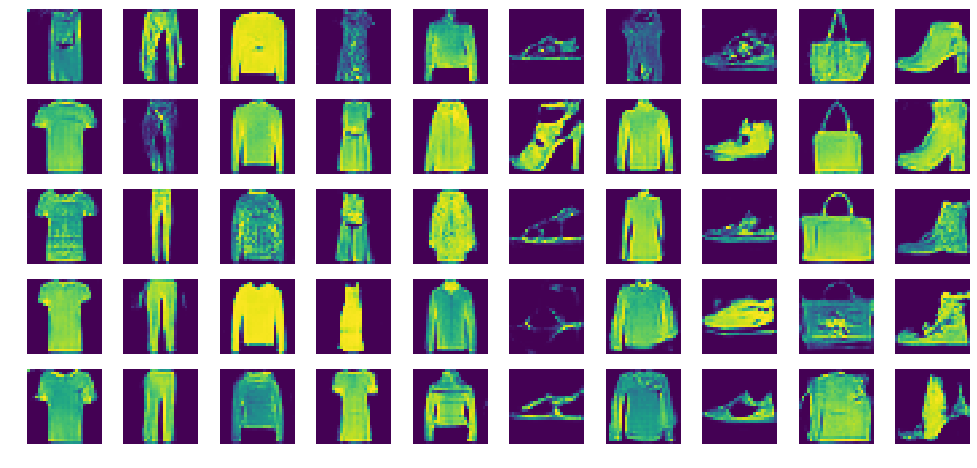

Epoch --> 95
Discriminator's Loss on real: 0.7779 and fake: 1.4754 Images; Generator's Loss: 3.8436


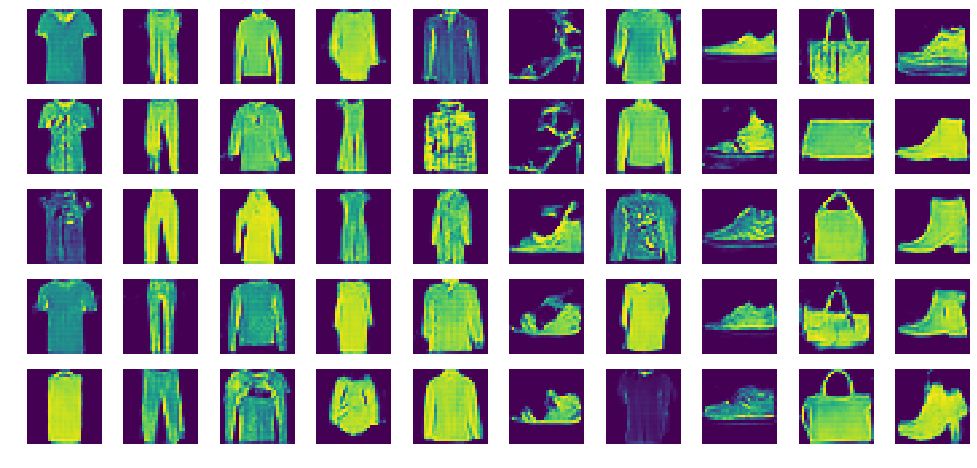

Epoch --> 100
Discriminator's Loss on real: 0.1395 and fake: 1.3699 Images; Generator's Loss: 3.8470


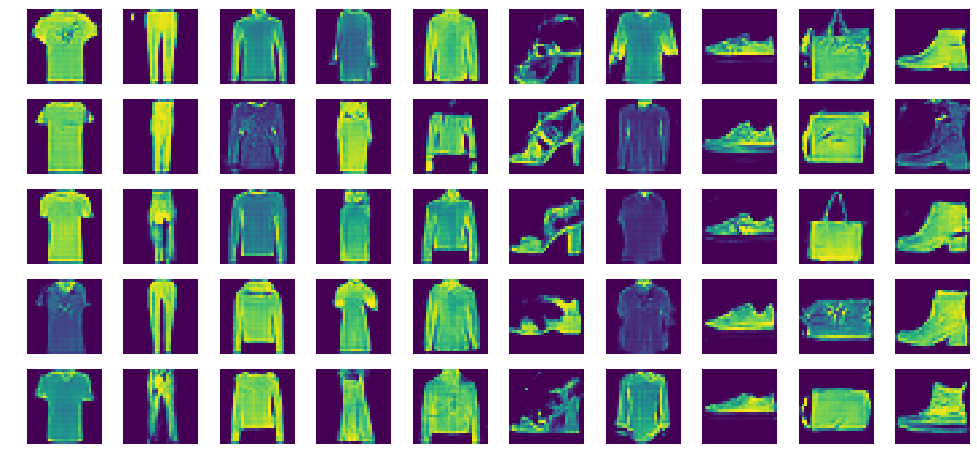

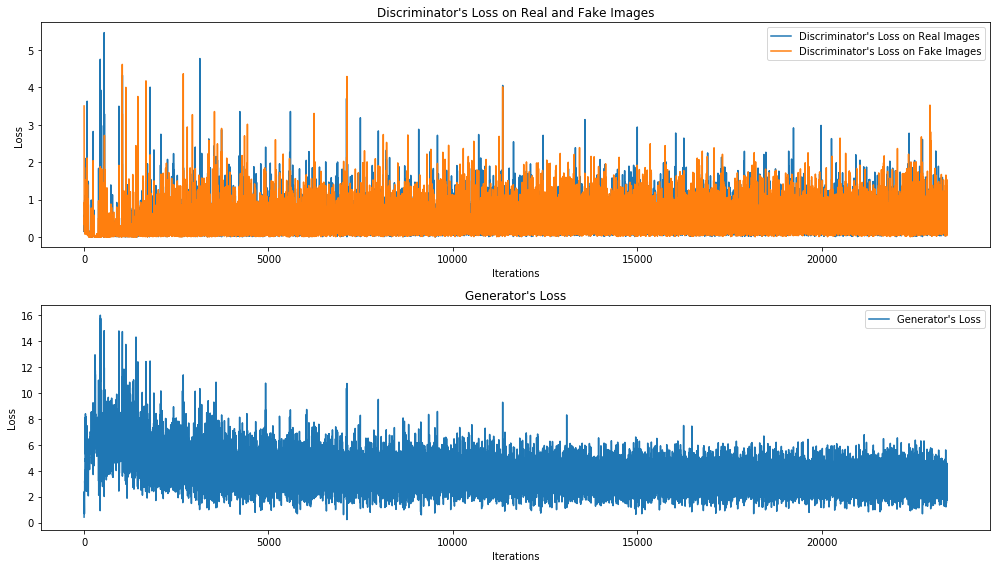

CPU times: user 1h 34min 40s, sys: 46min 4s, total: 2h 20min 45s
Wall time: 3h 15min 46s


In [0]:
# calculate execution time
%%time
# size of latent space
latent_dim = 300
# number of epochs
n_epochs = 100
# load image data
dataset = load_real_samples()
# create comoposite GAN model
gan_model = build_gan(g_model, d_model)
# train GAN
train_gan(g_model, d_model, gan_model, dataset, latent_dim, n_epochs)

## Create and Display GIF

In [0]:
# create a gif from specified intervals
gif_file = 'cgan-mnist.gif'

with imageio.get_writer(gif_file, mode='I') as writer:
    filenames = glob.glob('image_at_epoch*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [0]:
# display the gif
import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=gif_file)

![cgan-mnist](cgan-mnist.gif)

## Download GIF

In [0]:
# dowmload the gif
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(gif_file)

## References
[Conditional Generative Adversarial Networks](https://arxiv.org/pdf/1411.1784.pdf)

[Conditional GAN (CGAN) on Fashion MNIST Dataset using Keras](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/)